In [1]:
%matplotlib inline

import sys
import math
import outliers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

prescription = pd.read_csv('data/prescriptions2017_clean.csv.gz', compression='gzip')

In [2]:
medications = outliers.getOverdoseMedications(prescription)
medications.shape

(73,)

In [3]:
all_times  = []

for med in np.asarray(medications):

    methods_time = pd.DataFrame()
    
    X, Y = outliers.getPrescriptions(prescription, med)
    anomalies = len(Y[Y==1])
    total = len(X)
    
    if len(X) < 30000:
        continue

    print(med + ', Size: ', total, ' Overdose: ', anomalies)
        
    index_list = np.append([], [])
    skf = StratifiedKFold(n_splits=anomalies)
    div = 1
    for train_index, test_index in skf.split(X, Y):
            
            
        index_list = np.append(index_list.astype(int), test_index.astype(int))
        size = len(index_list)
            
        X_train = X[index_list]
        Y_train = Y[index_list]
        overdose_size = len(Y_train[Y_train==1])
        
        if (size // 3000) < div:
            continue
            
        size_idx = div * 3000
        div = 1 + (size // 3000)
        
        sys.stdout.write(str(overdose_size) + '/' + str(size) +', ')
            
        epsilon = 0.5
        p_svm = [epsilon,4]
        p_cov = [epsilon]
        p_ift = [epsilon]
        p_lof = [500,epsilon]
        p_wpr = [epsilon]
        p_gmx = [epsilon]
        results = outliers.evaluateMethods(X_train, Y_train, p_svm, p_cov, p_ift, p_lof, p_wpr, p_gmx, debug=False)

        for idx in results.index:
            methods_time.loc[idx, size_idx] = results.loc[idx,'Time']

        if size > 30000:
            break

    all_times.append(methods_time)
        #break
    
    if len(all_times) > 5:
        break
            
print('Done')

DIPIRONA 1 g/2 ml SOL INJ, Size:  163027  Overdose:  618
12/3168, 23/6072, 35/9240, 46/12144, 57/15048, 69/18216, 80/21120, 91/24024, 103/27192, 114/30096, LACTULOSE 667 mg/ml SOL ORAL, Size:  33395  Overdose:  90
9/3344, 17/6312, 25/9280, 33/12248, 41/15216, 49/18184, 57/21152, 65/24120, 73/27088, 81/30056, PARACETAMOL 500 mg CP, Size:  82749  Overdose:  116
5/3570, 9/6426, 13/9282, 17/12138, 22/15708, 26/18564, 30/21420, 34/24276, 38/27132, 43/30700, Done


In [4]:
all_times[1]

,3000,6000,9000,12000,15000,18000,21000,24000,27000,30000
DDC-H,0.052,0.062,0.070,0.083,0.091,0.100,0.102,0.146,0.122,0.131
SVM,0.265,0.940,2.008,3.574,5.637,8.156,11.188,14.763,18.792,23.472
IsoF,0.311,0.493,0.683,0.857,1.145,1.269,1.494,1.668,1.890,2.070
DDC-C,0.071,0.087,0.107,0.132,0.146,0.160,0.165,0.210,0.208,0.222
Gau,0.006,0.013,0.022,0.022,0.046,0.063,0.048,0.044,0.078,0.055
Cov,0.424,0.511,0.592,0.687,0.930,1.002,1.163,1.208,1.633,1.618
DDC,0.049,0.060,0.068,0.080,0.088,0.164,0.097,0.111,0.114,0.122
LOF,0.398,0.839,1.364,1.738,2.436,3.084,3.678,4.126,4.718,5.060
DDC-J,0.040,0.048,0.053,0.060,0.066,0.071,0.073,0.081,0.085,0.089


In [7]:
mean_time = pd.DataFrame(np.zeros((9,10)), index=results.index, columns=np.arange(3000,30001,3000))

for df in all_times:
    for m in df.index:
        for s in df.columns:
            mean_time.loc[m,s] += df.loc[m,s]

mean_time = ( mean_time.values / len(all_times) )
mean_time = pd.DataFrame(mean_time, index=results.index, columns=np.arange(3000,30001,3000))
mean_time

,3000,6000,9000,12000,15000,18000,21000,24000,27000,30000
DDC-H,0.031667,0.035667,0.041333,0.046667,0.051333,0.055667,0.065000,0.073667,0.067000,0.075000
SVM,0.194000,0.688000,1.484667,2.534333,4.035333,5.797000,7.861667,10.327333,13.108667,16.410000
IsoF,0.247333,0.389000,0.532667,0.659667,0.848333,0.976000,1.135667,1.315667,1.445000,1.594000
DDC-C,0.037667,0.045333,0.062333,0.065000,0.071667,0.077667,0.081667,0.097667,0.098000,0.104000
Gau,0.006000,0.012000,0.020667,0.022333,0.027667,0.041667,0.034667,0.030667,0.044333,0.037667
Cov,0.326667,0.404667,0.499333,0.547667,0.692667,0.760667,0.879667,0.966333,1.172333,1.244333
DDC,0.028333,0.034667,0.040000,0.045333,0.049667,0.076333,0.055333,0.060667,0.063000,0.067000
LOF,0.437333,0.885333,1.484667,1.976333,2.774333,3.580667,4.277333,5.059000,5.934000,6.706000
DDC-J,0.025000,0.029667,0.033667,0.037667,0.041333,0.044333,0.046667,0.050000,0.054667,0.055667


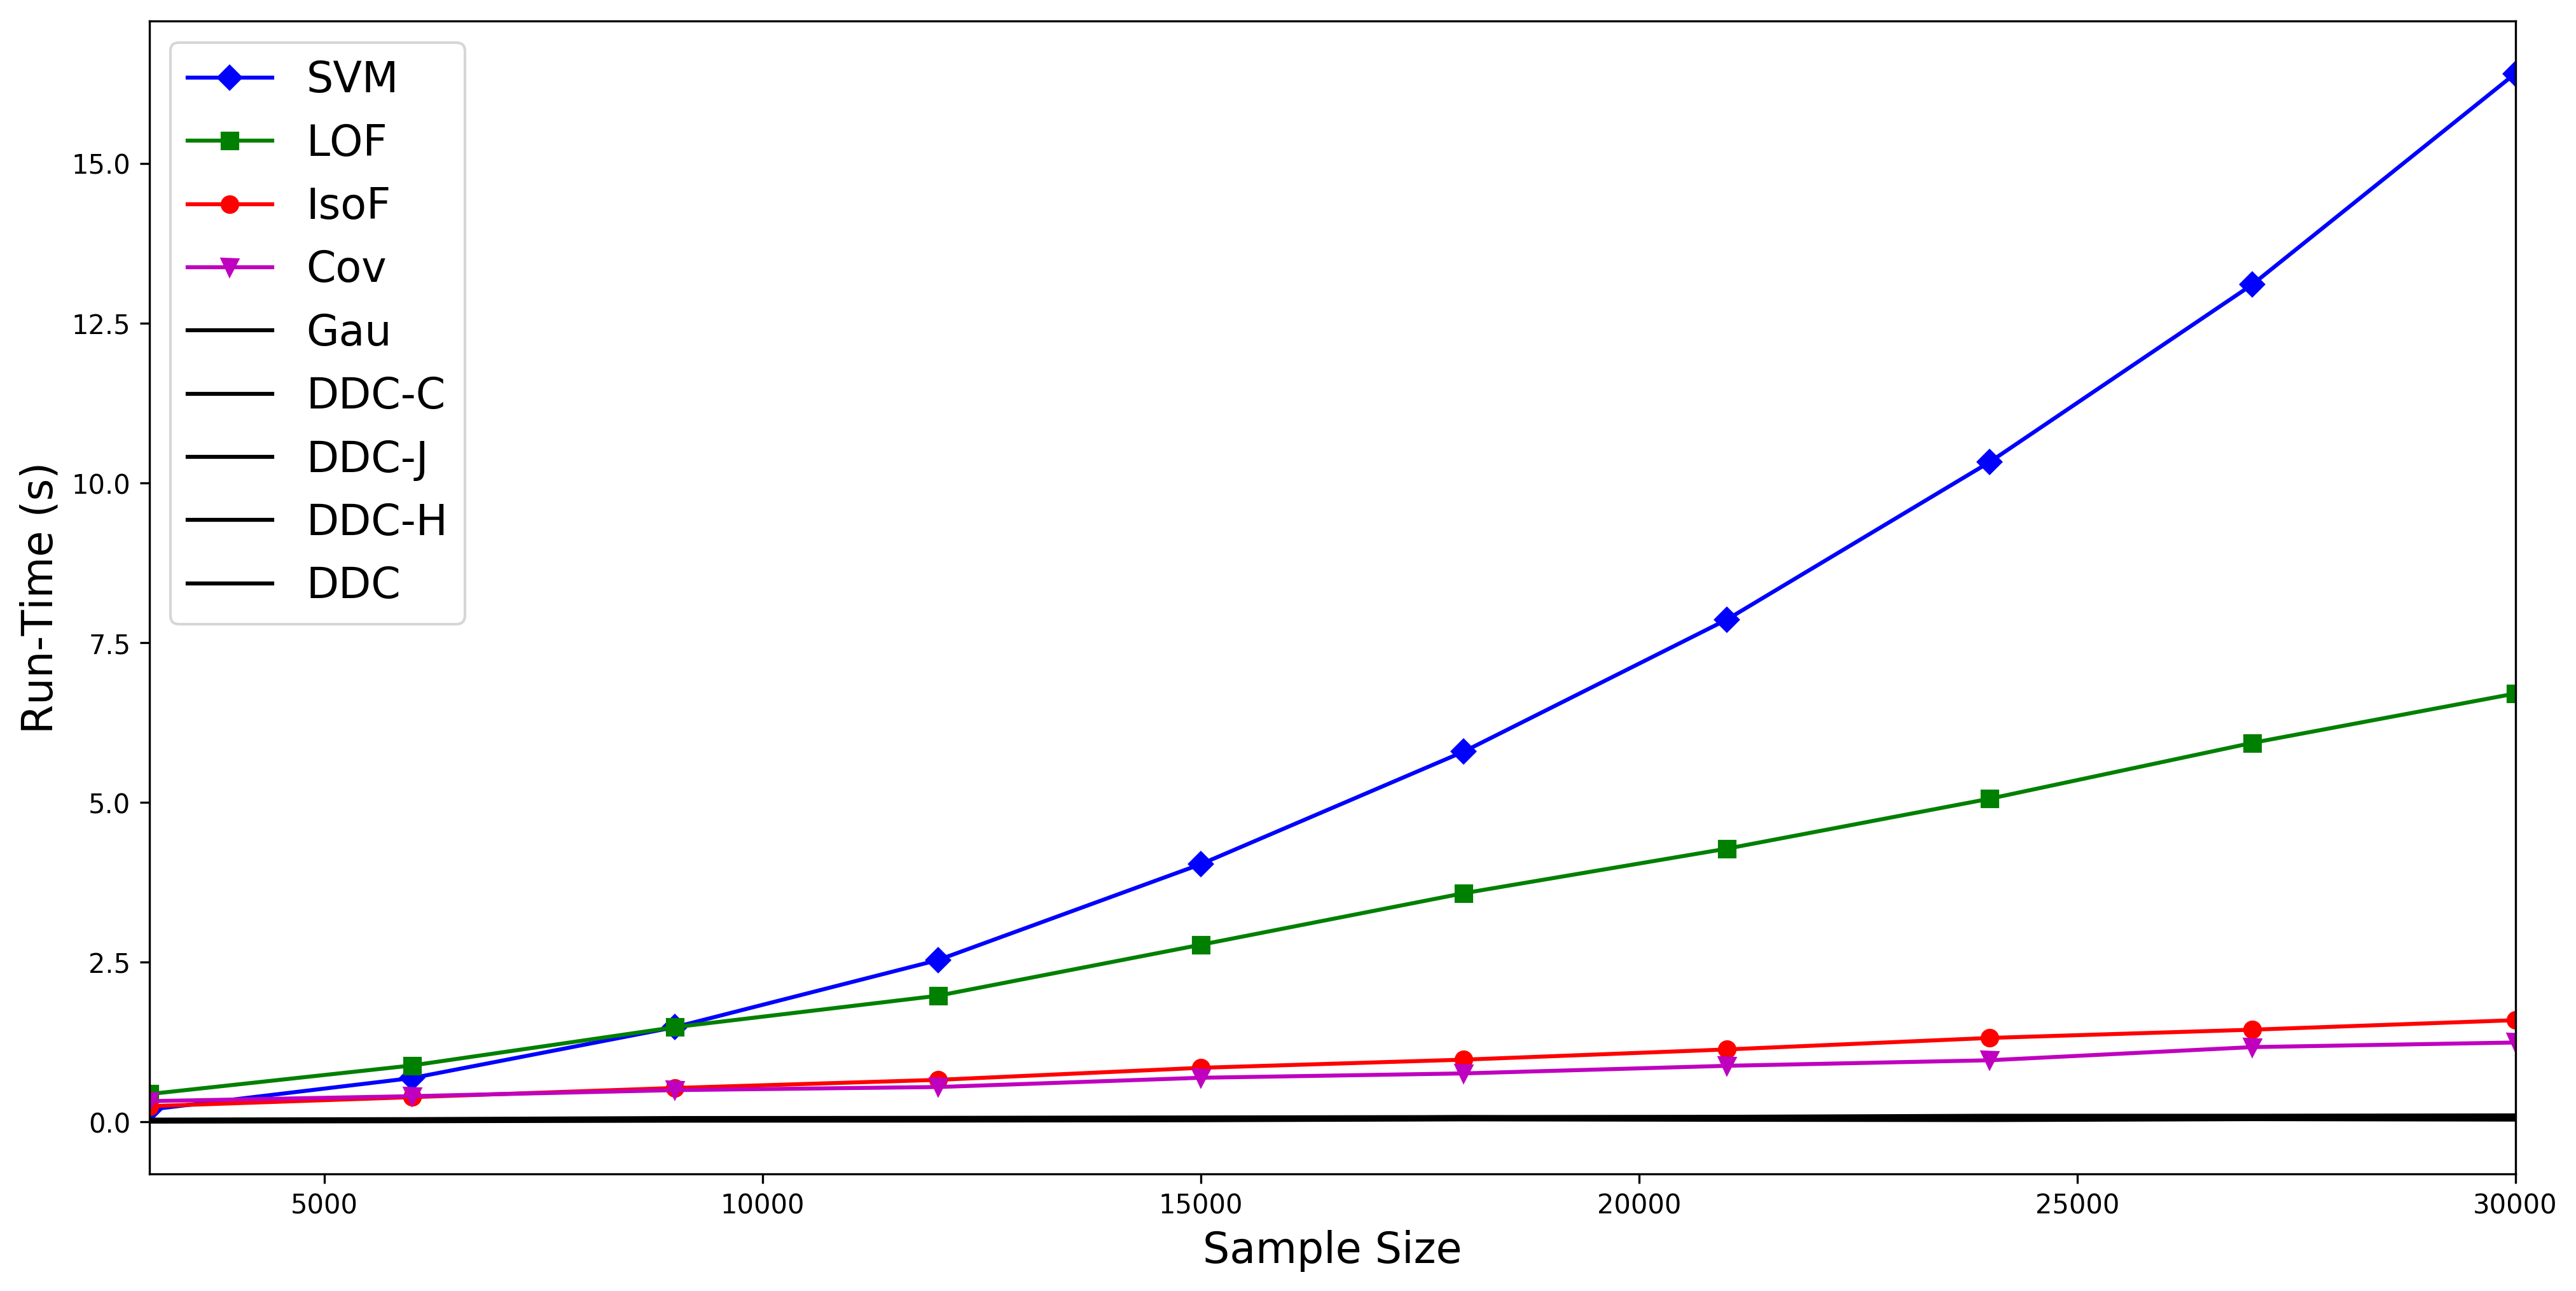

In [9]:
plt.figure(figsize=(16, 8), dpi= 300)
methods = ['SVM','LOF','IsoF','Cov','Gau','DDC-C','DDC-J','DDC-H','DDC']
colors = ['b', 'g', 'r', 'm', 'k', 'k', 'k', 'k', 'k', 'k']
markers = ['D', 's', 'o', 'v', '', '', '', '', '', '']
i = 0
for m in methods:
    plt.plot(np.asarray(mean_time.columns),np.asarray(mean_time.loc[m].values), 
             c=colors[i],
             marker=markers[i],
             label=m)
    i += 1
    
plt.legend(fontsize=16)
plt.xlabel('Sample Size', fontsize=16)
plt.ylabel('Run-Time (s)', fontsize=16)
#plt.ylim(0,22)
plt.xlim(3000,30000)
plt.show()